<a href="https://colab.research.google.com/github/Dinarque/INALCO_Inalco_M2_ingenierie_connaissances_2025_eleves/blob/main/TP/TP2_Les_deux_bases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 : Les deux bases

Les graphes de connaissance ont des emplois de plus en plus variés dans les applications logicielles. Mais stocker des graphes complexes (dont les noeuds ont des attributs, qui peuvent avoir différents types d'arrête...) est compliqué dans une base de données classique.

D'où l'essor des bases de données de types graphes depuis les années 2000. Toutefois on reproche souvent aux bases de données graphe des performances moyennes, et d'être peu compréhensibles tant leur fonctionnement diffère des autres bases NoSQL.

L'objectif de ce TP est d'implémenter une base de données à base de graphes from scratch à partir d'une autre base de données NoSQL.
Donc les deux bases.


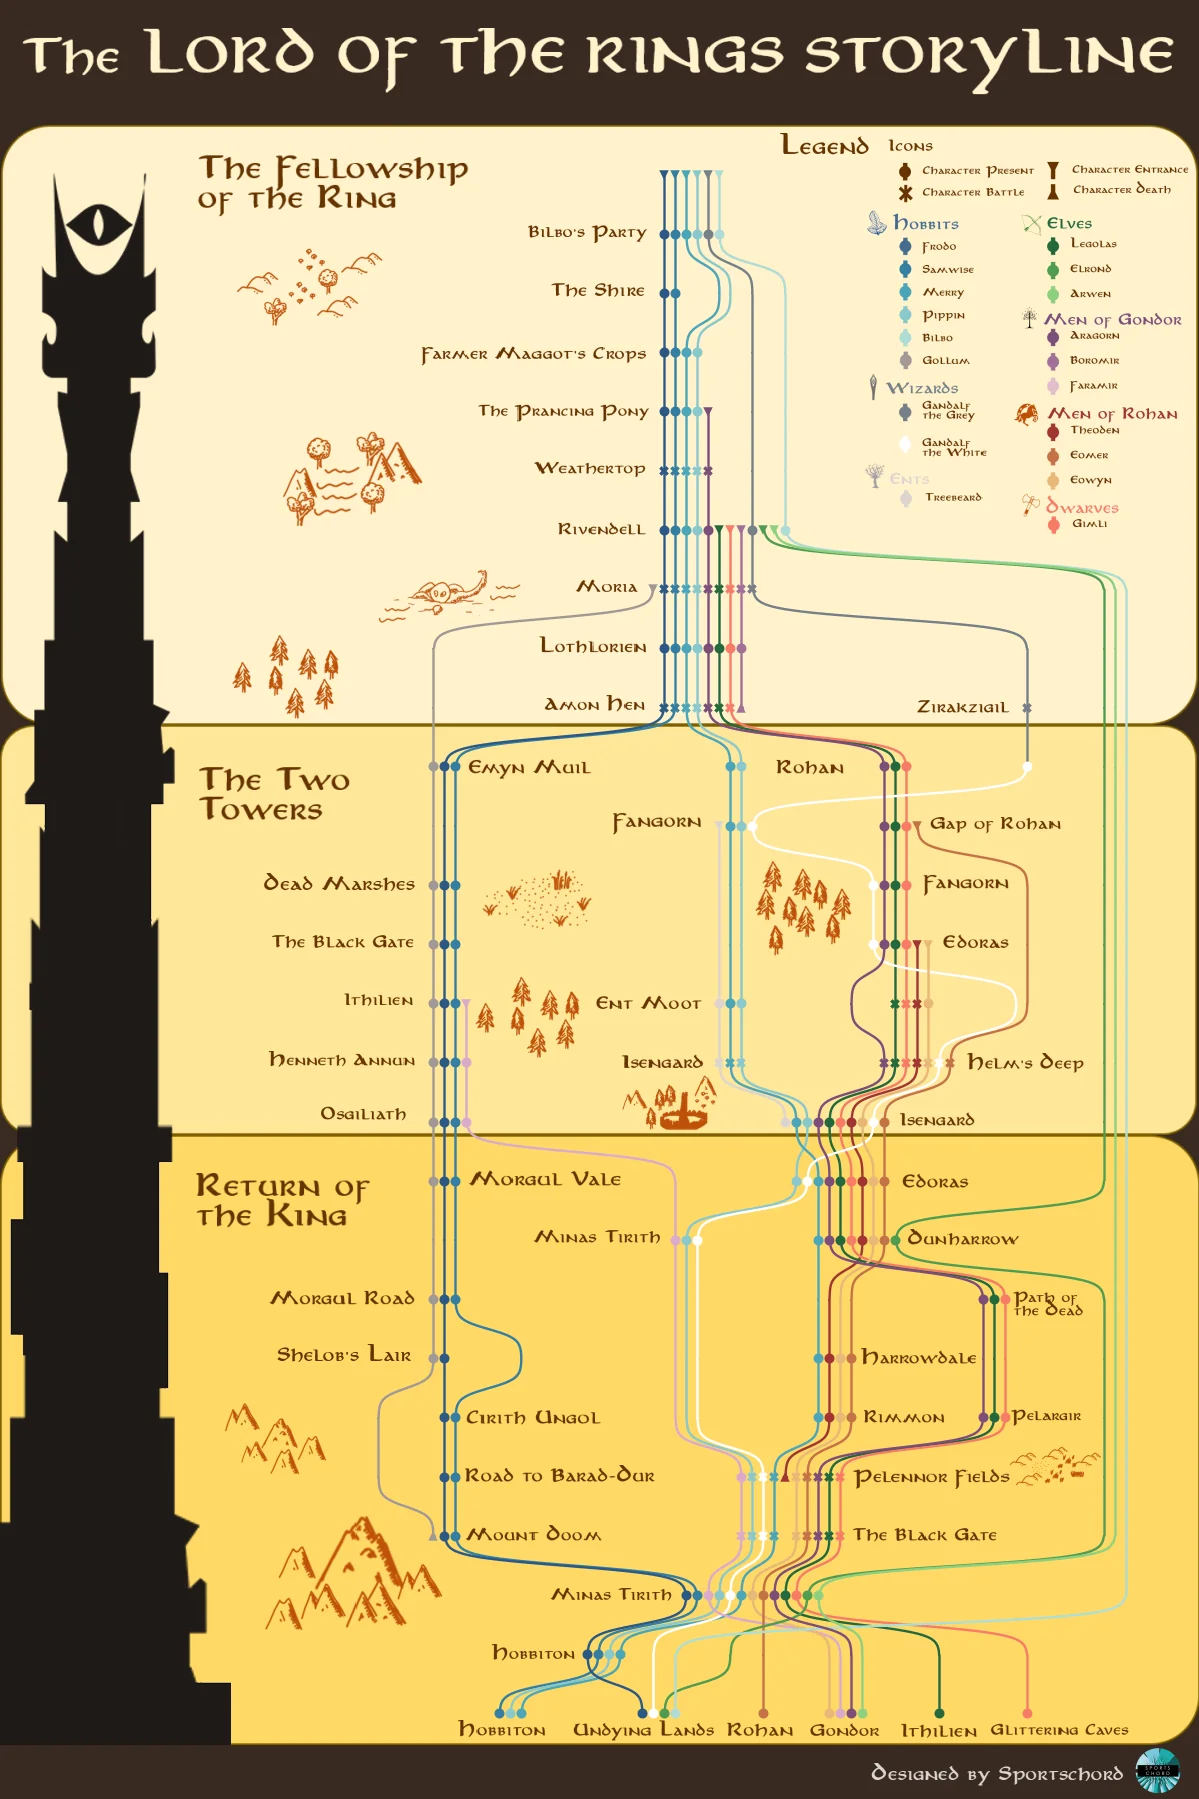

Lien vers l'illustration : https://i.redd.it/fl09ourn6yh21.png

Objectifs pédagogiques:
* Comprendre le fonctionnement d'une base de données à base de graphe en recodant certaines des opérations de bases
* Réviser la programmation objets
* Comprendre et appliquer plusieurs algorithmes classiques sur les graphes (clustering, courts chemins)
* Se poser des questions sur les critères d'une bonne base de donnée (latence, place mémoire, ...)


# Partie 1 : Le CRUD /8

Le but de cette partie est de créer les fondations d'une base de données qui permette de créer, requêter, modifier et détruire les objets (principe du CRUD commun à toute base de données).

Vous devez pour cela créez des classes pour les objets à stocker ainsi que une classe pour la base de données. Ajoutez des méthodes au fur et à mesure pour permettre le CRUD.

# 1) Create /3

* créez une classe pour les noeuds  
un noeud a un nom principal, éventuellement une classe et des propriétés (couples clé/valeur).
créer une méthode qui génère un id unique à partir de la classe et du nom notamment.
selon le principe de "index free adjacency" un objet stocke également la liste de ses voisins (ids)

* créez une classe pour les edges
avec comme information source_id, target_id, éventuellent la classe du noeud et des propriétés

* créez une classe OneRingDB qui réprésente la base de données.
La base de donnée a comme champs un dic mappant les id des noeuds aux objets noeuds, et un autre mappant les id des edges aux objets.

* écrivez une méthode pour créer noeud et edge

In [10]:
import uuid

class Node:
    def __init__(self, name, node_class=None, properties=None):
        self.name = name
        self.node_class = node_class
        self.properties = properties or {}
        self.neighbors = set()  # index-free adjacency: stocke les ids des voisins
        self.id = self.generate_id()

    def generate_id(self):
        base = f"{self.node_class or 'Any'}::{self.name}"
        return str(uuid.uuid5(uuid.NAMESPACE_DNS, base))  # stable et unique

    def add_neighbor(self, neighbor_id):
        self.neighbors.add(neighbor_id)

    def __repr__(self):
        return f"<Node {self.name} [{self.node_class}] {self.id[:8]}>"

class Edge:
    def __init__(self, source_id, target_id, edge_class=None, properties=None):
        self.source_id = source_id
        self.target_id = target_id
        self.edge_class = edge_class
        self.properties = properties or {}
        self.id = self.generate_id()

    def generate_id(self):
        base = f"{self.edge_class or 'Any'}::{self.source_id}->{self.target_id}"
        return str(uuid.uuid5(uuid.NAMESPACE_DNS, base))

    def __repr__(self):
        return f"<Edge {self.source_id[:6]}->{self.target_id[:6]} [{self.edge_class}]>"

class OneRingDB:
    def __init__(self):
        self.nodes = {}  # id -> Node
        self.edges = {}  # id -> Edge

    def create_node(self, name, node_class=None, properties=None):
        node = Node(name, node_class, properties)
        self.nodes[node.id] = node
        return node

    def create_edge(self, source_id, target_id, edge_class=None, properties=None):
        if source_id not in self.nodes or target_id not in self.nodes:
            raise ValueError("Source or target node does not exist.")
        edge = Edge(source_id, target_id, edge_class, properties)
        self.edges[edge.id] = edge
        self.nodes[source_id].add_neighbor(target_id)
        self.nodes[target_id].add_neighbor(source_id)  # si graphe non orienté
        return edge


# 2) Read /3

* écrivez une méthode qui permet de trouver un noeud depuis son id

* écrivez une méthode qui permet de trouvez un edge depuis son id

* écrivez une méthode qui permet de trouver un noeud depuis son nom, voire de renvoyer les noeuds qdont le nom matche un début de chaîne de caractère

* écrivez une méthode qui permet de retrouver une edge depuis le nom de la source et celui de la destination

In [11]:
class OneRingDB:
    def __init__(self):
        self.nodes = {}  # id -> Node
        self.edges = {}  # id -> Edge

    def create_node(self, name, node_class=None, properties=None):
        node = Node(name, node_class, properties)
        self.nodes[node.id] = node
        return node

    def create_edge(self, source_id, target_id, edge_class=None, properties=None):
        if source_id not in self.nodes or target_id not in self.nodes:
            raise ValueError("Source or target node does not exist.")
        edge = Edge(source_id, target_id, edge_class, properties)
        self.edges[edge.id] = edge
        self.nodes[source_id].add_neighbor(target_id)
        self.nodes[target_id].add_neighbor(source_id)  # graphe non orienté
        return edge

    # Méthode 1 : trouver un noeud par son id
    def get_node_by_id(self, node_id):
        return self.nodes.get(node_id)

    # Méthode 2 : trouver une edge par son id
    def get_edge_by_id(self, edge_id):
        return self.edges.get(edge_id)

    # Méthode 3 : trouver un ou plusieurs noeuds par nom (exact ou préfixe)
    def find_nodes_by_name(self, name_prefix):
        return [node for node in self.nodes.values() if node.name.startswith(name_prefix)]

    # Méthode 4 : retrouver une edge via le nom de source et destination
    def find_edge_by_node_names(self, source_name, target_name):
        source_nodes = self.find_nodes_by_name(source_name)
        target_nodes = self.find_nodes_by_name(target_name)
        for edge in self.edges.values():
            if any(n.id == edge.source_id for n in source_nodes) and \
               any(n.id == edge.target_id for n in target_nodes):
                return edge
        return None  # ou liste si plusieurs possibles


# 3) Update /1

* écrivez des méthodes permettant d'update un noeud et un edge.

* testez les pour ajouter des propriétés


# 4) Delete /1


* ajoutez des méthodes de suppression pour les noeuds et les arrêtes

In [12]:
import uuid

# --- Bloc 1 : CREATE ---
class Node:
    def __init__(self, name, node_class=None, properties=None):
        self.name = name
        self.node_class = node_class
        self.properties = properties or {}
        self.neighbors = set()
        self.id = self.generate_id()

    def generate_id(self):
        base = f"{self.node_class or 'Any'}::{self.name}"
        return str(uuid.uuid5(uuid.NAMESPACE_DNS, base))

    def add_neighbor(self, neighbor_id):
        self.neighbors.add(neighbor_id)

    def __repr__(self):
        return f"<Node {self.name} [{self.node_class}] {self.id[:8]}>"

class Edge:
    def __init__(self, source_id, target_id, edge_class=None, properties=None):
        self.source_id = source_id
        self.target_id = target_id
        self.edge_class = edge_class
        self.properties = properties or {}
        self.id = self.generate_id()

    def generate_id(self):
        base = f"{self.edge_class or 'Any'}::{self.source_id}->{self.target_id}"
        return str(uuid.uuid5(uuid.NAMESPACE_DNS, base))

    def __repr__(self):
        return f"<Edge {self.source_id[:6]}->{self.target_id[:6]} [{self.edge_class}]>"

class OneRingDB:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def create_node(self, name, node_class=None, properties=None):
        node = Node(name, node_class, properties)
        self.nodes[node.id] = node
        return node

    def create_edge(self, source_id, target_id, edge_class=None, properties=None):
        if source_id not in self.nodes or target_id not in self.nodes:
            raise ValueError("Source or target node does not exist.")
        edge = Edge(source_id, target_id, edge_class, properties)
        self.edges[edge.id] = edge
        self.nodes[source_id].add_neighbor(target_id)
        self.nodes[target_id].add_neighbor(source_id)
        return edge

    # --- Bloc 2 : READ ---
    def get_node_by_id(self, node_id):
        return self.nodes.get(node_id)

    def get_edge_by_id(self, edge_id):
        return self.edges.get(edge_id)

    def find_nodes_by_name(self, name_prefix):
        return [node for node in self.nodes.values() if node.name.startswith(name_prefix)]

    def find_edge_by_node_names(self, source_name, target_name):
        source_nodes = self.find_nodes_by_name(source_name)
        target_nodes = self.find_nodes_by_name(target_name)
        for edge in self.edges.values():
            if any(n.id == edge.source_id for n in source_nodes) and \
               any(n.id == edge.target_id for n in target_nodes):
                return edge
        return None

    # --- Bloc 3 : UPDATE ---
    def update_node(self, node_id, new_properties):
        node = self.get_node_by_id(node_id)
        if node:
            node.properties.update(new_properties)
            return True
        return False

    def update_edge(self, edge_id, new_properties):
        edge = self.get_edge_by_id(edge_id)
        if edge:
            edge.properties.update(new_properties)
            return True
        return False
    
        # --- Bloc 4 : DELETE ---
    def delete_node(self, node_id):
        if node_id not in self.nodes:
            return False

        # Supprimer toutes les arêtes liées à ce nœud
        edges_to_delete = [eid for eid, edge in self.edges.items()
                           if edge.source_id == node_id or edge.target_id == node_id]
        for eid in edges_to_delete:
            self.delete_edge(eid)

        # Supprimer des voisins
        for neighbor_id in self.nodes[node_id].neighbors:
            if neighbor_id in self.nodes:
                self.nodes[neighbor_id].neighbors.discard(node_id)

        del self.nodes[node_id]
        return True

    def delete_edge(self, edge_id):
        edge = self.edges.get(edge_id)
        if not edge:
            return False

        # Mise à jour des voisins
        if edge.source_id in self.nodes:
            self.nodes[edge.source_id].neighbors.discard(edge.target_id)
        if edge.target_id in self.nodes:
            self.nodes[edge.target_id].neighbors.discard(edge.source_id)

        del self.edges[edge_id]
        return True


# --- Test ---
if __name__ == "__main__":
    db = OneRingDB()

    # Création de deux nœuds
    frodo = db.create_node("Frodo", "Hobbit")
    gandalf = db.create_node("Gandalf", "Wizard")

    # Création d'une arête entre eux
    edge = db.create_edge(frodo.id, gandalf.id, "FRIENDS_WITH")

    print("Avant update :")
    print(frodo)
    print(gandalf)
    print(edge)

    # Ajout de propriétés
    db.update_node(frodo.id, {"age": 50, "ring_bearer": True})
    db.update_edge(edge.id, {"since": "TA 3018"})

    print("\nAprès update :")
    print(frodo.properties)
    print(gandalf.properties)
    print(edge.properties)


Avant update :
<Node Frodo [Hobbit] 889f290b>
<Node Gandalf [Wizard] f036821c>
<Edge 889f29->f03682 [FRIENDS_WITH]>

Après update :
{'age': 50, 'ring_bearer': True}
{}
{'since': 'TA 3018'}


# Partie 2)  La fenêtre de vision /6

On dispose maintenant d'une base de données avec laquelle on peut interagir basiquement (créer des objets, les rechercher...)  
Il faut maintenant permettre à des utilisateurs extérieurs d'interagir avec elle !



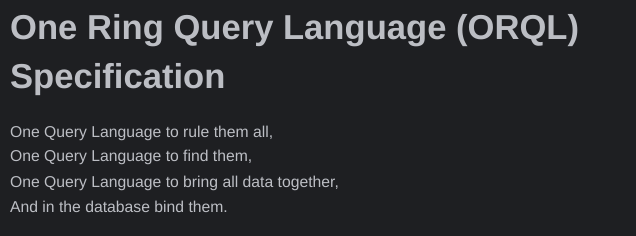

#5) Un language unique pour tout agencer /3

Le but de cette question est de créer un langage de requête pour permettre aux utilisateurs d'utiliser votre système.

Vous trouverez en annexe un fichier en markdown décrivant un langage de requête basique.

étudiez ce language. Il vous faudra coder un parseur pour le décoder et lancer les.

* écrivez un parseur ORQueryParser qui prenne en entrée une requête de ORQL, détermine si elle est valide ou pas, la décompose correctement et renvoie un objet python représentant la requête. le but de cette phase est d'isoler les éléments clés (node_id, classe, propriétés, conditions ...)

* écrivez une classe ORQueryExecutor qui prend en entrée une requête, l'analyse avec le parseur, puis exécute la ou les bonnes méthodes de la base.

* Faites en sorte que toutes les opérations du CRUD soient bien utilisables.

In [13]:
import re
import ast

class ORQueryParser:
    def parse(self, query):
        query = query.strip()

        # CREATE NODE
        if query.startswith("CREATE (:"):
            return self._parse_create_node(query)

        # CREATE EDGE
        if query.startswith("CREATE ["):
            return self._parse_create_edge(query)

        # READ
        if query.startswith("READ (:"):
            return self._parse_read_node(query)

        # UPDATE
        if query.startswith("UPDATE (:"):
            return self._parse_update_node(query)

        # DELETE
        if query.startswith("DELETE (:"):
            return self._parse_delete_node(query)

        raise ValueError(f"Unsupported ORQL query: {query}")

    def _extract_properties(self, props_str):
        # Ex : '{name: "Frodo", age: 50}' → dict
        props_str = props_str.strip()
        if not props_str:
            return {}
        # Remplace name: "Frodo" → "name": "Frodo"
        json_like = re.sub(r'(\w+)\s*:', r'"\1":', props_str)
        return ast.literal_eval(json_like)

    def _parse_create_node(self, query):
        # CREATE (:Class {props})
        match = re.match(r'CREATE\s+\(:([\w]+)\s*(\{.*\})?\)', query)
        if not match:
            raise ValueError("Invalid CREATE node syntax")
        node_class, props = match.groups()
        return {
            "action": "CREATE_NODE",
            "class": node_class,
            "properties": self._extract_properties(props or "")
        }

    def _parse_create_edge(self, query):
        # CREATE [:CLASS {props}] FROM "X" TO "Y"
        match = re.match(r'CREATE\s+\[:([\w]+)\s*(\{.*\})?\]\s+FROM\s+"([^"]+)"\s+TO\s+"([^"]+)"', query)
        if not match:
            raise ValueError("Invalid CREATE edge syntax")
        edge_class, props, source, target = match.groups()
        return {
            "action": "CREATE_EDGE",
            "class": edge_class,
            "properties": self._extract_properties(props or ""),
            "source_name": source,
            "target_name": target
        }

    def _parse_read_node(self, query):
        # READ (:Class) WHERE key = "val"
        match = re.match(r'READ\s+\(:([\w]+)\)\s+WHERE\s+(\w+)\s*=\s*"([^"]+)"', query)
        if not match:
            raise ValueError("Invalid READ syntax")
        node_class, key, value = match.groups()
        return {
            "action": "READ_NODE",
            "class": node_class,
            "filter": {key: value}
        }

    def _parse_update_node(self, query):
        # UPDATE (:Class) SET key = val WHERE key = val
        match = re.match(r'UPDATE\s+\(:([\w]+)\)\s+SET\s+(.*?)\s+WHERE\s+(\w+)\s*=\s*"([^"]+)"', query)
        if not match:
            raise ValueError("Invalid UPDATE syntax")
        node_class, set_clause, where_key, where_val = match.groups()
        # SET key = val, key2 = val2
        updates = {}
        for part in set_clause.split(","):
            k, v = part.strip().split("=")
            updates[k.strip()] = ast.literal_eval(v.strip())
        return {
            "action": "UPDATE_NODE",
            "class": node_class,
            "updates": updates,
            "filter": {where_key: where_val}
        }

    def _parse_delete_node(self, query):
        # DELETE (:Class) WHERE key = val
        match = re.match(r'DELETE\s+\(:([\w]+)\)\s+WHERE\s+(\w+)\s*=\s*"([^"]+)"', query)
        if not match:
            raise ValueError("Invalid DELETE syntax")
        node_class, key, val = match.groups()
        return {
            "action": "DELETE_NODE",
            "class": node_class,
            "filter": {key: val}
        }


In [14]:
parser = ORQueryParser()
req = parser.parse('CREATE (:Character {name: "Frodo", age: 50})')
print(req)

{'action': 'CREATE_NODE', 'class': 'Character', 'properties': {'name': 'Frodo', 'age': 50}}


In [15]:
class ORQueryExecutor:
    def __init__(self, db):
        self.db = db
        self.parser = ORQueryParser()

    def execute(self, query):
        parsed = self.parser.parse(query)
        action = parsed["action"]

        if action == "CREATE_NODE":
            return self.db.create_node(
                name=parsed["properties"].get("name"),
                node_class=parsed["class"],
                properties=parsed["properties"]
            )

        elif action == "CREATE_EDGE":
            source_nodes = self.db.find_nodes_by_name(parsed["source_name"])
            target_nodes = self.db.find_nodes_by_name(parsed["target_name"])
            if not source_nodes or not target_nodes:
                raise ValueError("Source or target node not found by name")
            return self.db.create_edge(
                source_id=source_nodes[0].id,
                target_id=target_nodes[0].id,
                edge_class=parsed["class"],
                properties=parsed["properties"]
            )

        elif action == "READ_NODE":
            # Lire tous les nœuds de la classe et filtrer
            results = []
            for node in self.db.nodes.values():
                if node.node_class == parsed["class"]:
                    if all(node.properties.get(k) == v for k, v in parsed["filter"].items()):
                        results.append(node)
            return results

        elif action == "UPDATE_NODE":
            updated = []
            for node in self.db.nodes.values():
                if node.node_class == parsed["class"]:
                    if all(node.properties.get(k) == v for k, v in parsed["filter"].items()):
                        node.properties.update(parsed["updates"])
                        updated.append(node)
            return updated

        elif action == "DELETE_NODE":
            deleted = []
            for node in list(self.db.nodes.values()):
                if node.node_class == parsed["class"]:
                    if all(node.properties.get(k) == v for k, v in parsed["filter"].items()):
                        self.db.delete_node(node.id)
                        deleted.append(node)
            return deleted

        else:
            raise ValueError(f"Unknown action: {action}")


In [16]:
db = OneRingDB()
executor = ORQueryExecutor(db)

# Création
executor.execute('CREATE (:Character {name: "Frodo", age: 50})')
executor.execute('CREATE (:Character {name: "Gandalf", age: 2019})')
executor.execute('CREATE [:FRIENDS_WITH {since: "3018"}] FROM "Frodo" TO "Gandalf"')

# Lecture
print(executor.execute('READ (:Character) WHERE name = "Frodo"'))

# Update
executor.execute('UPDATE (:Character) SET age = 51 WHERE name = "Frodo"')

# Delete
executor.execute('DELETE (:Character) WHERE name = "Gandalf"')


[<Node Frodo [Character] 453b7cda>]


[<Node Gandalf [Character] cdab939a>]

# 6) L'épreuve du feu /1

* écrivez un script pour charger des donneés dans la base (fichier lotr_dataset_small, puis bientôt large)

* Assurez vous que les fonctionnalités du CRUD fonctionnent bien en testant le fichier de requêtes requetes_CRUD.txt (mieux de le faire après avoir fait la question 7) )

In [19]:
# Test lecture
print("\n READ Frodo:")
res = executor.execute('READ (:Character) WHERE name = "Frodo"')
print(res[0].properties)

# Test update
print("\n UPDATE age de Frodo à 51")
executor.execute('UPDATE (:Hobbit) SET age = 51 WHERE name = "Frodo"')
print(db.find_nodes_by_name("Frodo")[0].properties)

# Test delete
print("\n DELETE Gollum")
executor.execute('DELETE (:Creature) WHERE name = "Gollum"')
print("Gollum" in [n.name for n in db.nodes.values()])



 READ Frodo:
{'name': 'Frodo', 'age': 51}

 UPDATE age de Frodo à 51
{'name': 'Frodo', 'age': 51}

 DELETE Gollum
False


# 7) Le pouvoir de la vision /2

* designez une interface streamlit qui permette à l'utilisateur d'interagir avec la base de données.

* L'utilisateur peur pouvoir charger un fichier json contenant la liste de noeuds et relations et cela doit les charger dans la page

* sur la page de gauche (sidebar), l'utilisateur doit pouvoir entrer des requêtes en ORQL  

* sur la page principale, doivent apparaître des informations sur la constitution de la base et surtout un joli graphe interactif.

# Partie 3 :  L'armée de fonctionnalités

Le but de cette partie est d'ajouter de nouvelles fonctionnalités à la base et au language de requête

#8)  Trouver les plus courts chemins et colorer /2

Le but de cette question est d'ajouter de nouvelles fonctionnalités reposant sur les propriétés des graphes.

* networkx est une librairie qui propose déjà implémentés de nombreux algorithmes usuels sur les graphes.  écrivez une fonction qui convertisse le graphe de la base de données en graphe nx

* utilisez les algorithmes de la librairie pour ajouter le calcul du plus court chemin entre deux noeuds.  implémenez le mot clé LINK dans ORQL pour permettre le calcul des chemins.  Ajoutez une option pour que la direction des liens ne compte pas

* Renseignez-vous sur le coloriage de graphe. à quoi cela peut-il servir ? quel est l'algorithme usuel qui le fait ? décrivez son fonctionnement

* implémentez la fonctionnalité et ajoutez le mot clé COLOR dans ORQL

Le coloriage : attribuer une couleur à chaque nœud d’un graphe de sorte que deux nœuds adjacents n’aient jamais la même couleur. il sert à modéliser des problèmes d’allocation de ressources sans conflit.

L’algorithme est le greedy coloring. Il parcourt les nœuds un par un (souvent dans un ordre optimisé, comme "plus grand degré d’abord") et attribue à chaque nœud la plus petite couleur disponible qui ne soit pas utilisée par ses voisins. C’est simple mais pas toujours optimal (le nombre de couleurs peut être supérieur au minimum théorique, appelé "nombre chromatique").

Dans orql_core.py,  on fait :
```
colors = nx.coloring.greedy_color(G, strategy="largest_first")
```

#9) Diviser pour mieux régner /2

* implémentez l'algorithme de clustering de Louvain à partir de la librairie de votre choix.  ajoutez le mot clé CLUSTER dans ORQL

* grâce à des techniques d'analyse de réseau, taggez les noeuds particulier dans le graphe (HUB...) en créant un nouveau champs dans l'objet noeud. une requête READ(:Hubs) doit permettre de tous les retrouver aussi.

* implémetnez une nouvelle fonctionnalité de votre choix associée à un nouveau mot clé dans ORQL.  

* décrivez quelle est cette fonctionnalité et comment vous avez décidé de l'implémenter

## Nouvelle fonctionnalité:
CONNECTED_COMPONENTS
### Description
La commande ORQL CONNECTED_COMPONENTS permet d’identifier automatiquement toutes les composantes connexes du graphe courant, c’est-à-dire les sous-graphes dans lesquels tous les nœuds sont reliés directement ou indirectement entre eux.
Cette fonctionnalité est utile pour : repérer des groupes isolés ou indépendants dans un graphe mieux comprendre la structure globale d’un graphe hétérogène, détecter des erreurs.

### Implémentation
Elle s’appuie sur la fonction connected_components() de la bibliothèque networkx. Pour cela : Le graphe interne de OneRingDB est converti en un Graph de networkx. On applique nx.connected_components(G) pour obtenir une liste d’ensembles de nœuds. Pour chaque composante, on extrait les noms des nœuds et leur taille. Le résultat est retourné sous forme de liste de dictionnaires :

[
  {"component": 0, "size": 4, "nodes": ["Frodo", "Sam", "Gandalf", "The Shire"]},
  {"component": 1, "size": 2, "nodes": ["Gollum", "Mordor"]},
  ...
]


#10) La base face au nombre /2

Les bases de données de type graphe ont de mauvaise réputation de performances. Notre base de donnée n'est pas une vraie base de donnée car elle est stateless, il n'y a pas de stockage et il faut la relancer à chaque fois. Mais une fois le chargement effectué on peut l'utiliser comme une base de données avec toutes les données en cache. étudions les limites.

* chargez le gros dataset lotr_dataset_large dans la base.

* Le but de cette question est de tester les performances des différentes opérations : le chargement des objets dans la base, la recherche d'un objet par son nom, la recherche de plus court chemin et le clustering.

* On veut tester ces opérations pour 10 noeuds, 100, 1000 et si possible 1000. Créez un corpus de noeuds  et arrêtes adapté  à chaque fois

* créez un corpus de autant de requêtes ORQL qu'il y a de noeuds (sauf pour le clustering bien sûr) et calculez le temps moyen par requête pour chaque opération

* présentez les résultats dans un tableau et commentez les

Maintenant que vous avez bien travaillé, amusez vous avec votre base de données pour répondre aux questions suivantes :)
* quels sont tous les personnages qui ont été corrompus par Sauron ?
* Combien-y-a t'il d'elfes ?
* Quelles sont les armes utilisées par les orques ?
Faites preuve d'imagination !

1. Une personne: `["Saruman", "Isengard", "CONTROLS", { "through": "corruption" }]`

2. Il y a 3 elfes. Voici l'output que j'ai eu après la requête `READ (:Elf)`
```
[
0:{
"name":"Legolas"
"class":"Elf"
"properties":{
"name":"Legolas"
}
}
1:{
"name":"Elrond"
"class":"Elf"
"properties":{
"name":"Elrond"
}
}
2:{
"name":"Galadriel"
"class":"Elf"
"properties":{
"name":"Galadriel"
}
}
]
```

3. Après avoir rajouté des armes avec les requêtes `CREATE (:Weapon {name: "Jagged Blade"})` etc. et, `READ (:Weapon)`:
```
[
0:{
"name":"Jagged Blade"
"class":"Weapon"
"properties":{
"name":"Jagged Blade"
}
}
1:{
"name":"Orcish Bow"
"class":"Weapon"
"properties":{
"name":"Orcish Bow"
}
}
2:{
"name":"Uruk-hai Axe"
"class":"Weapon"
"properties":{
"name":"Uruk-hai Axe"
}
}
]
```

# BONUS : la base de la base

Rendez la base de données stateless (c'est à dire que les données sont conservées d'une exécution du code à l'autre).

Pour se faire:
* utilisez une structure de données adaptée pour stocker les objets déjà chargés dans la base
* modifiez les méthodes de recherche pour que ce soit cette base de fond qui soit requêtée et qu'on ait pas besoin de recharger tous les objets dans la mémoire vive
* Refaites les tests de performance. Que constatez-vous ?

Nous avons rendu la base de données stateless en stockant automatiquement tous les nœuds et arêtes dans un fichier persistent_db.json. À chaque modification (CREATE, UPDATE, DELETE), l’état est sauvegardé. Lors de l’instanciation de la base, le fichier est rechargé automatiquement.

Les performances des opérations (READ, LINK, CLUSTER) devraient améliorer dès que le chargement initial est évité. Le temps de CREATE tombe à zéro si les données sont déjà persistées.

In [1]:
PERSISTENCE_FILE = "persistent_db.json"
def __init__(self):
    self.nodes = {}
    self.edges = {}
    self.load_from_disk()


def save_to_disk(self):
    data = {
        "nodes": {
            node.id: {
                "name": node.name,
                "class": node.node_class,
                "properties": node.properties,
                "neighbors": list(node.neighbors)
            } for node in self.nodes.values()
        },
        "edges": {
            edge.id: {
                "source": edge.source_id,
                "target": edge.target_id,
                "class": edge.edge_class,
                "properties": edge.properties
            } for edge in self.edges.values()
        }
    }
    with open(PERSISTENCE_FILE, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)


def load_from_disk(self):
    if not os.path.exists(PERSISTENCE_FILE):
        return
    with open(PERSISTENCE_FILE, "r", encoding="utf-8") as f:
        data = json.load(f)
    for node_id, node_data in data["nodes"].items():
        node = Node(node_data["name"], node_data["class"], node_data["properties"])
        node.id = node_id
        node.neighbors = set(node_data["neighbors"])
        self.nodes[node_id] = node
    for edge_id, edge_data in data["edges"].items():
        edge = Edge(edge_data["source"], edge_data["target"], edge_data["class"], edge_data["properties"])
        edge.id = edge_id
        self.edges[edge_id] = edge


In [ ]:
self.save_to_disk()
return node